# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import datetime
import cv2
from PIL import Image
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


# defining custom functions to read and resize images 
def imread(path):
    from PIL import Image
    return np.array(Image.open(path))

def imresize(img, size):
    from PIL import Image
    return np.array(Image.fromarray(img).resize(size))





We set the random seed so that the results don't vary drastically.

In [ ]:
# We set the random seed so that the results don't vary drastically.
import random as rn
np.random.seed(30)
rn.seed(30)

import tensorflow as tf
tf.random.set_seed(30)




In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [ ]:
# Initialising train and validation files

train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 32 #experiment with the batch size

Sample Image


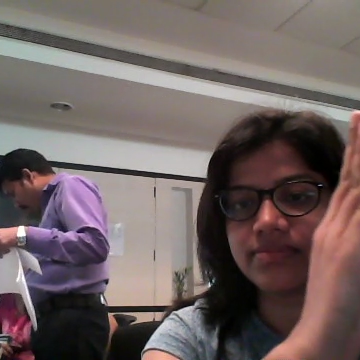

In [ ]:
# Print Sample image
print('Sample Image')
path_of_image= 'Project_data'+'/'+ 'train'+'/'+'WIN_20180907_15_35_09_Pro_Right Swipe_new'+'/'+'WIN_20180907_15_35_09_Pro_00014.png'
image = Image.open(path_of_image)
image.show()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [ ]:
img_idx = [i for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video 
frames= len(img_idx) #x: number of images used for each video
width= 80
height= 80
# (width,height) is the final size of the input images and 3 is the number of channels RGB
# Assuming the size of cropped input image is consistent: 80x80

In [ ]:
def generator(source_path, folder_list, batch_size):
    
    print( 'Source path = ', source_path, '; batch size =', batch_size)

    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/(batch_size))  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,frames,width,height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    
                     #crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    path_of_image= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = imread(path_of_image)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    if image.shape[0]!= image.shape[1]:  ##Checking for square frames 360x360
                        image= image[0:120, 20:140, :]   ##Crops Rectangular frames of 120x160 to 120x120
                    
                    image = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 80x80

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        
        if len(t)!= num_batches*batch_size:
            batch_size= len(t) - (num_batches*batch_size)
            batch= num_batches
            batch_data = np.zeros((batch_size,frames,width,height,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    path_of_image= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = imread(path_of_image)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = cv2.resize(image, (width,height), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 80x80

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = './Project_data/train'
val_path = './Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
# Importing all modelling packages
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, MaxPooling3D,MaxPooling2D,Conv2D,GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Dropout, BatchNormalization, ZeroPadding3D, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.python.keras.layers.recurrent import LSTM




Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
# Creating generator 

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_loss",patience=30,mode="auto",verbose=1)


LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)# write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
input_shape= (frames,width,height,3)

# Convolutional 3D model

## Model 1

In [ ]:
## Model1



# 16,32,64 kernels in 3 consecutive conv3D layers
model1 = Sequential()


# 1st Layer Group
model1.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model1.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model1.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation('relu'))
model1.add(MaxPooling3D(pool_size=(2,2,2)))


# FC layer group
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.5))
# Softmax Layer
model1.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:

optimiser = Adam()#write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
batch_normalization (BatchNo (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation (Activation)      (None, 15, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 40, 40, 32)     13856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 40, 40, 32)     128       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 40, 40, 32)     0

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
history1=model1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=[checkpoint,earlystop], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  ./Project_data/train ; batch size = 32
Epoch 1/30
21/21 [==============================] - 98s 5s/step - loss: 9.8178 - categorical_accuracy: 0.2470 - val_loss: 2.8625 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-5.70151-0.31071-2.86249-0.21000.h5
Epoch 2/30
21/21 [==============================] - 20s 1s/step - loss: 1.3081 - categorical_accuracy: 0.4404 - val_loss: 1.5452 - val_categorical_accuracy: 0.3125

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.22828-0.48240-1.54520-0.31250.h5
Epoch 3/30
21/21 [==============================] - 17s 850ms/step - loss: 1.1591 - categorical_accuracy: 0.5377 - val_loss: 1.8755 - val_categorical_accuracy: 0.3125

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.09080-0.56440-1.87553-0.31250.h5
Epoch 4/30
21/21 [==============================] - 16s 776ms/step - loss: 1.0519 - categorical_accuracy: 0.5

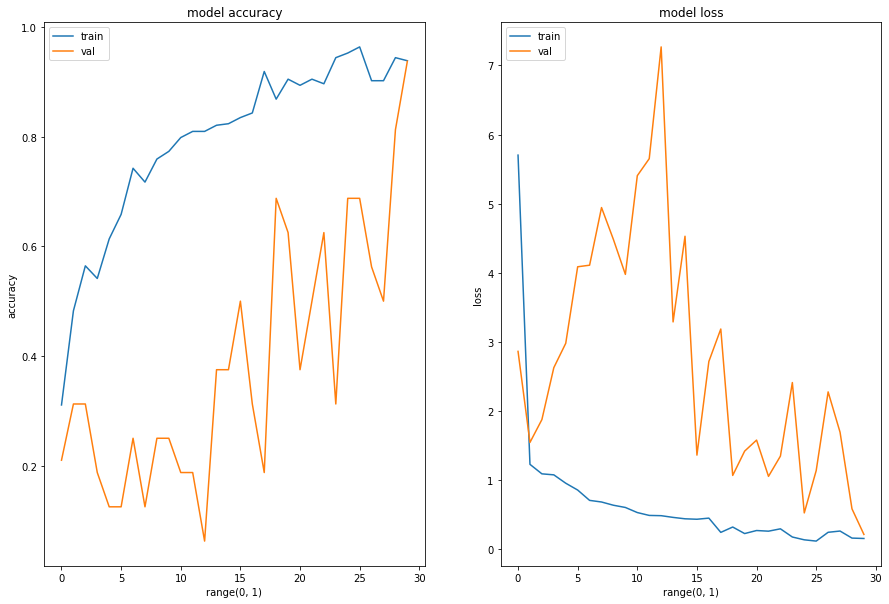

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history1.history['categorical_accuracy'])
plt.plot(history1.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observation**
The model performs well with good training and validation accuracy.

**Decision** 
Explore if changing the optimizer (Model 2) improves accuracy and proceed with model building (Model 3) using the better optimizer.

## Model 2

In [ ]:


# Model 2 

# 16,32,64 kernels in 3 consecutive conv3D layers
model2 = Sequential()
# 1st Layer Group
model2.add(Conv3D(16, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model2.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model2.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model2.add(BatchNormalization())
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))

# FC layer group
model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.25))
# Softmax Layer
model2.add(Dense(5, activation='softmax'))



In [ ]:

optimiser = SGD()#write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 80, 80, 16)    1312      
_________________________________________________________________
batch_normalization_3 (Batch (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation_3 (Activation)    (None, 15, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 40, 40, 32)     13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 40, 40, 32)     128       
_________________________________________________________________
activation_4 (Activation)    (None, 7, 40, 40, 32)    

In [ ]:
history2=model2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=[checkpoint,earlystop], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 15s 712ms/step - loss: 4.7259 - categorical_accuracy: 0.2273 - val_loss: 1.5264 - val_categorical_accuracy: 0.1875

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-3.03296-0.31373-1.52641-0.18750.h5
Epoch 2/30
21/21 [==============================] - 14s 713ms/step - loss: 1.3146 - categorical_accuracy: 0.4059 - val_loss: 1.5486 - val_categorical_accuracy: 0.5000

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.26176-0.45938-1.54857-0.50000.h5
Epoch 3/30
21/21 [==============================] - 15s 726ms/step - loss: 1.0463 - categorical_accuracy: 0.5542 - val_loss: 1.9537 - val_categorical_accuracy: 0.1250

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.04227-0.53221-1.95365-0.12500.h5
Epoch 4/30
21/21 [==============================] - 14s 672ms/step - loss: 1.0769 - categorical_accuracy: 0.5854 - val_loss: 2.2044 - val_categorical_accurac

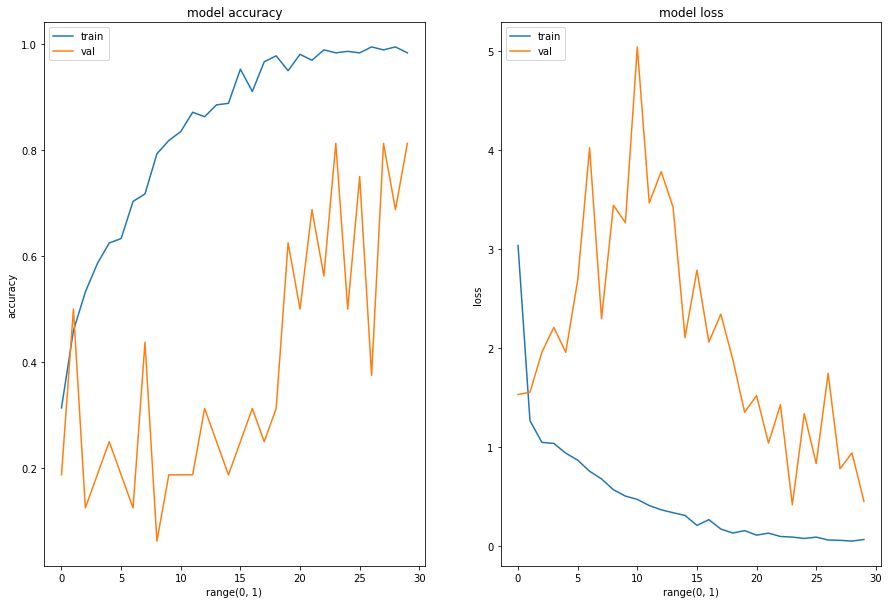

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observation**
Changing the optimizer to SGD resulted in overfitting on  train data and drop in validation accuracy.

**Decision** 
Explore if increasing number of neurons while using Adam as optimizer (Model 3) will improve the accuracy.

## Model 3

In [ ]:


# Model 3
# 32,64,64 kernels in 3 consecutive conv3D layers
model3 = Sequential()
# 1st Layer Group
model3.add(Conv3D(32, kernel_size=(3,3,3), input_shape=input_shape,padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model3.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model3.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model3.add(BatchNormalization())
model3.add(Activation('relu'))
model3.add(MaxPooling3D(pool_size=(2,2,2)))

# FC layer group
model3.add(Flatten())
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.5))
# Softmax Layer
model3.add(Dense(5, activation='softmax'))



In [ ]:

optimiser = Adam()#write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_6 (Conv3D)            (None, 15, 80, 80, 32)    2624      
_________________________________________________________________
batch_normalization_6 (Batch (None, 15, 80, 80, 32)    128       
_________________________________________________________________
activation_6 (Activation)    (None, 15, 80, 80, 32)    0         
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 7, 40, 40, 32)     0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 7, 40, 40, 64)     55360     
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 40, 40, 64)     256       
_________________________________________________________________
activation_7 (Activation)    (None, 7, 40, 40, 64)    

In [ ]:
history3=model3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=[checkpoint,earlystop], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 15s 678ms/step - loss: 10.2418 - categorical_accuracy: 0.2366 - val_loss: 2.2902 - val_categorical_accuracy: 0.1250

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-6.65474-0.27731-2.29015-0.12500.h5
Epoch 2/30
21/21 [==============================] - 14s 715ms/step - loss: 1.6119 - categorical_accuracy: 0.3253 - val_loss: 2.1367 - val_categorical_accuracy: 0.0625

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.55225-0.32213-2.13669-0.06250.h5
Epoch 3/30
21/21 [==============================] - 15s 758ms/step - loss: 1.3444 - categorical_accuracy: 0.4166 - val_loss: 1.3444 - val_categorical_accuracy: 0.3125

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.31125-0.45938-1.34444-0.31250.h5
Epoch 4/30
21/21 [==============================] - 13s 656ms/step - loss: 1.2516 - categorical_accuracy: 0.4401 - val_loss: 2.1804 - val_categorical_accura

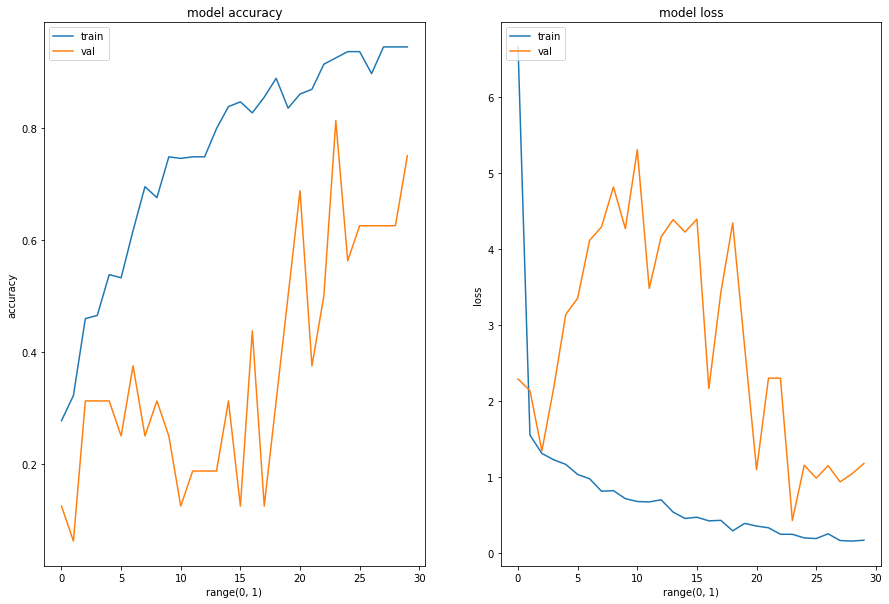

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history3.history['categorical_accuracy'])
plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:** There is no improvement with increase in number of neurons.

**Decision:** Exploring if changing the kernel size (Model 4) will improve model performance.



In [ ]:
# Model 4
# 32,64,64 kernels in 3 consecutive conv3D layers
model4 = Sequential()
# 1st Layer Group
model4.add(Conv3D(16, kernel_size=(5,5,5), input_shape=input_shape,padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))


# 2nd Layer Group
model4.add(Conv3D(32, kernel_size=(5,5,5),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# 3rd Layer Group
model4.add(Conv3D(64, kernel_size=(5,5,5),padding='same'))
model4.add(BatchNormalization())
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(2,2,2)))

# FC layer group
model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
# Softmax Layer
model4.add(Dense(5, activation='softmax'))


In [ ]:
optimiser = Adam() #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model4.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 15, 80, 80, 16)    6016      
_________________________________________________________________
batch_normalization_9 (Batch (None, 15, 80, 80, 16)    64        
_________________________________________________________________
activation_9 (Activation)    (None, 15, 80, 80, 16)    0         
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 7, 40, 40, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 7, 40, 40, 32)     64032     
_________________________________________________________________
batch_normalization_10 (Batc (None, 7, 40, 40, 32)     128       
_________________________________________________________________
activation_10 (Activation)   (None, 7, 40, 40, 32)    

In [ ]:
history4=model4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=[checkpoint,earlystop], validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/30
21/21 [==============================] - 15s 686ms/step - loss: 8.7350 - categorical_accuracy: 0.2298 - val_loss: 19.2735 - val_categorical_accuracy: 0.1250

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-5.55301-0.26050-19.27350-0.12500.h5
Epoch 2/30
21/21 [==============================] - 14s 680ms/step - loss: 1.7381 - categorical_accuracy: 0.3394 - val_loss: 7.7998 - val_categorical_accuracy: 0.0625

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.63158-0.33613-7.79983-0.06250.h5
Epoch 3/30
21/21 [==============================] - 15s 725ms/step - loss: 1.3733 - categorical_accuracy: 0.3651 - val_loss: 4.3334 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.37588-0.38375-4.33343-0.18750.h5
Epoch 4/30
21/21 [==============================] - 14s 698ms/step - loss: 1.2365 - categorical_accuracy: 0.4592 - val_loss: 1.6073 - val_categorical_accur

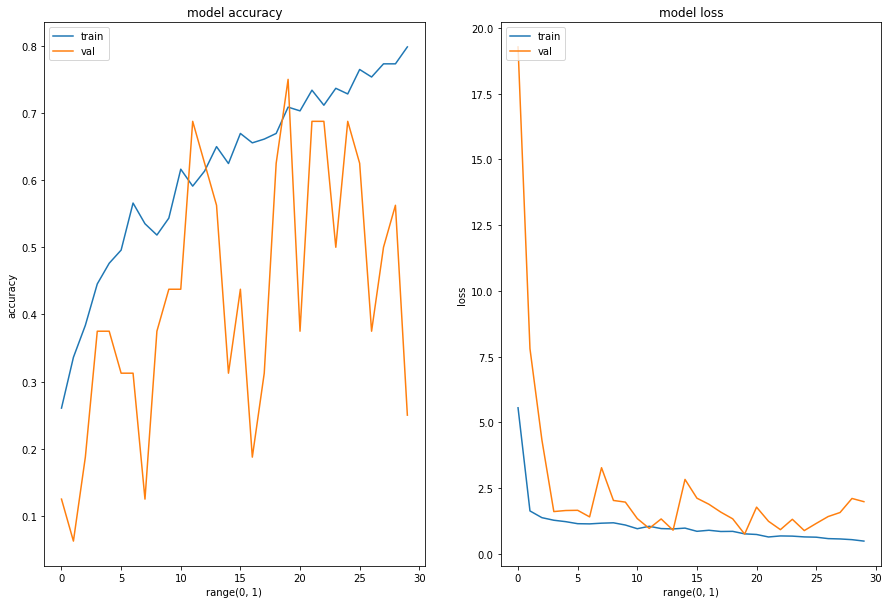

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history4.history['categorical_accuracy'])
plt.plot(history4.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:** There is no improvement with changing the kernel size.

**Decision:** Hence, the best Conv3D model is Model 1. Explore if Conv2d + LSTM will improve model performance.


# Convolutional 2D + RNN

## Model 5: CONV2d+RNN LSTM

In [ ]:
Input_shape=input_shape

# Model5
conv2d1 = Sequential()

#1st Conv2D group
conv2d1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
conv2d1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
conv2d1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
conv2d1.add(TimeDistributed(BatchNormalization()))
conv2d1.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
conv2d1.add(TimeDistributed(Flatten()))
#LSTM
conv2d1.add(LSTM(128, return_sequences=False, dropout=0.5))
conv2d1.add(Dense(64,activation='relu'))
conv2d1.add(Dropout(0.5))

#Softmax layer
conv2d1.add(Dense(5, activation='softmax'))



In [ ]:
optimiser = Adam() #write your optimizer
conv2d1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv2d1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 80, 80, 32)    896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 80, 80, 32)    9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 40, 40, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 40, 40, 64)   

In [ ]:


conv2d1_history= conv2d1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Epoch 1/30
21/21 [==============================] - 19s 726ms/step - loss: 1.7176 - categorical_accuracy: 0.2271 - val_loss: 1.7098 - val_categorical_accuracy: 0.1875

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-1.62953-0.25490-1.70981-0.18750.h5
Epoch 2/30
21/21 [==============================] - 14s 705ms/step - loss: 1.4604 - categorical_accuracy: 0.4304 - val_loss: 1.5462 - val_categorical_accuracy: 0.1875

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.48657-0.39776-1.54618-0.18750.h5
Epoch 3/30
21/21 [==============================] - 14s 701ms/step - loss: 1.4101 - categorical_accuracy: 0.4094 - val_loss: 1.9567 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.35243-0.43697-1.95674-0.25000.h5
Epoch 4/30
21/21 [==============================] - 14s 696ms/step - loss: 1.2163 - categorical_accuracy: 0.5323 - val_loss: 1.9471 - val_categorical_accurac

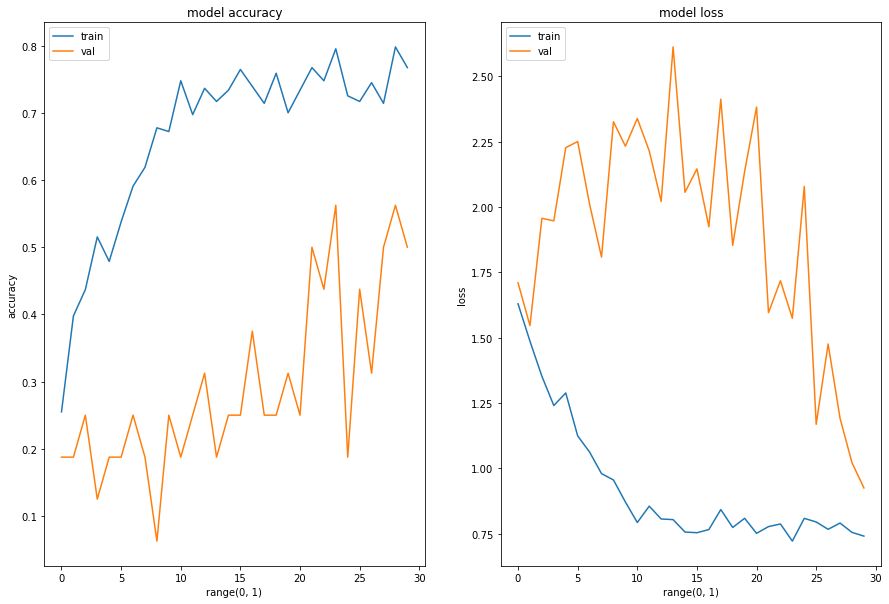

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(conv2d1_history.history['categorical_accuracy'])
plt.plot(conv2d1_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(conv2d1_history.history['loss'])
plt.plot(conv2d1_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:** This model performance is poor compared to Conv3D models. Validation losses are fluctuating without a concurrent gain in validation accuracy.

**Decision:** Explore if CONV2d +GRU LSTM (Conv2d2) performs better.

## Model 6 - CONV2d+GRU 

In [ ]:
Input_shape=input_shape

# Model 6
conv2d2 = Sequential()

#1st Conv2D group
conv2d2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
conv2d2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
conv2d2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu'), input_shape=Input_shape))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
conv2d2.add(TimeDistributed(BatchNormalization()))
conv2d2.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
conv2d2.add(TimeDistributed(Flatten()))
#LSTM
conv2d2.add(GRU(128, return_sequences=False, dropout=0.5))
conv2d2.add(Dense(64,activation='relu'))
conv2d2.add(Dropout(0.5))

#Softmax layer
conv2d2.add(Dense(5, activation='softmax'))



In [ ]:
optimiser = Adam() #write your optimizer
conv2d2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv2d2.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 80, 80, 32)    896       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 80, 80, 32)    9248      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 80, 80, 32)    128       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 40, 40, 32)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 40, 40, 64)    18496     
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 40, 40, 64)   

In [ ]:


conv2d2_history= conv2d2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Epoch 1/30
21/21 [==============================] - 17s 751ms/step - loss: 1.8661 - categorical_accuracy: 0.2619 - val_loss: 2.7283 - val_categorical_accuracy: 0.1250

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-1.71757-0.26331-2.72827-0.12500.h5
Epoch 2/30
21/21 [==============================] - 14s 713ms/step - loss: 1.4166 - categorical_accuracy: 0.3999 - val_loss: 2.7744 - val_categorical_accuracy: 0.1250

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.44976-0.40896-2.77435-0.12500.h5
Epoch 3/30
21/21 [==============================] - 13s 661ms/step - loss: 1.3215 - categorical_accuracy: 0.4871 - val_loss: 2.6023 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.28913-0.46779-2.60229-0.18750.h5
Epoch 4/30
21/21 [==============================] - 15s 730ms/step - loss: 1.1914 - categorical_accuracy: 0.5226 - val_loss: 3.1073 - val_categorical_accurac

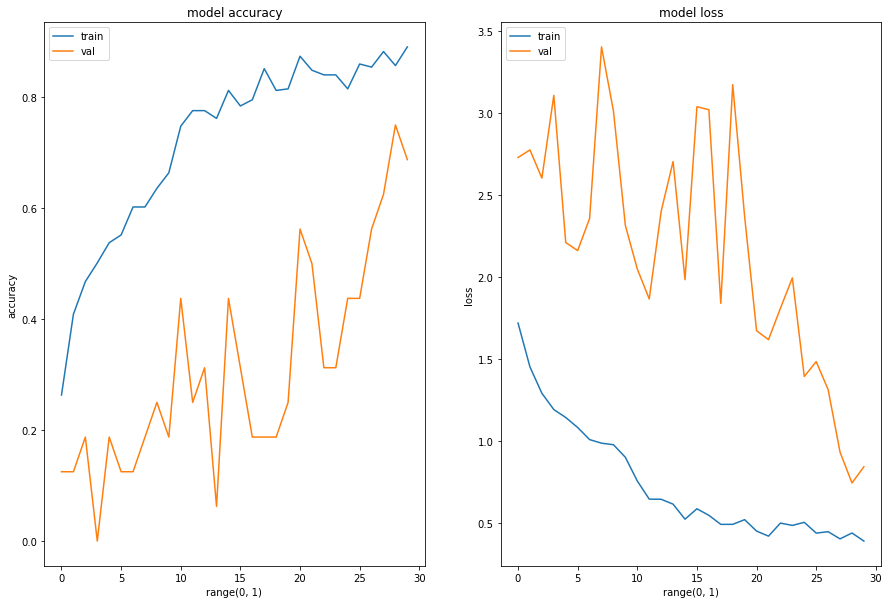

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(conv2d2_history.history['categorical_accuracy'])
plt.plot(conv2d2_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(conv2d2_history.history['loss'])
plt.plot(conv2d2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:** The training and validation accuracy is lower than the Conv2d1.

**Decision:** Explore if Transfer learning will produce better results.

## Model 7 - Transfer Learning imagenet+LSTM :-

In [ ]:
# Model 7
from tensorflow.keras.applications import mobilenet
mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

conv2d3 = Sequential()
conv2d3.add(TimeDistributed(mobilenet_transfer, input_shape=input_shape))

#Freeze layers
for layer in conv2d3.layers:
    layer.trainable = False
        
conv2d3.add(TimeDistributed(BatchNormalization()))
conv2d3.add(TimeDistributed(MaxPooling2D((2, 2))))

conv2d3.add(TimeDistributed(Flatten()))
conv2d3.add(LSTM(128,return_sequences=False, dropout=0.5))
conv2d3.add(Dense(64,activation='relu'))
conv2d3.add(Dropout(0.5))

#Softmax Layer
conv2d3.add(Dense(5, activation='softmax'))



In [ ]:
optimiser = Adam() #write your optimizer
conv2d3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (conv2d3.summary())


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 15, 2, 2, 1024)    3228864   
_________________________________________________________________
time_distributed_33 (TimeDis (None, 15, 2, 2, 1024)    4096      
_________________________________________________________________
time_distributed_34 (TimeDis (None, 15, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 15, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

In [ ]:


conv2d3_history= conv2d3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)



Epoch 1/30
21/21 [==============================] - 19s 723ms/step - loss: 1.6956 - categorical_accuracy: 0.2076 - val_loss: 1.5702 - val_categorical_accuracy: 0.5625

Epoch 00001: saving model to model_init_2022-07-1218_10_31.008073/model-00001-1.65811-0.22689-1.57018-0.56250.h5
Epoch 2/30
21/21 [==============================] - 14s 687ms/step - loss: 1.5459 - categorical_accuracy: 0.3347 - val_loss: 1.3763 - val_categorical_accuracy: 0.5625

Epoch 00002: saving model to model_init_2022-07-1218_10_31.008073/model-00002-1.54805-0.34174-1.37627-0.56250.h5
Epoch 3/30
21/21 [==============================] - 15s 752ms/step - loss: 1.3323 - categorical_accuracy: 0.5192 - val_loss: 1.1789 - val_categorical_accuracy: 0.7500

Epoch 00003: saving model to model_init_2022-07-1218_10_31.008073/model-00003-1.35199-0.48739-1.17889-0.75000.h5
Epoch 4/30
21/21 [==============================] - 13s 666ms/step - loss: 1.2406 - categorical_accuracy: 0.4860 - val_loss: 0.9508 - val_categorical_accurac

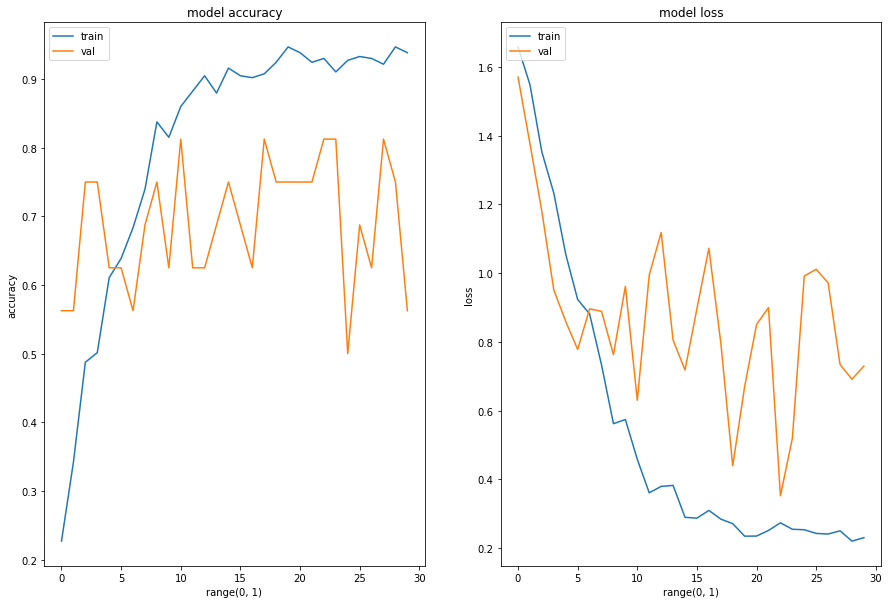

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(conv2d3_history.history['categorical_accuracy'])
plt.plot(conv2d3_history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(conv2d3_history.history['loss'])
plt.plot(conv2d3_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Observations:** Achieved good accuracy on train and validation data owing to the transfer learning. It has very few trainable parameters (600,965) compared to Model 1 which has similar performance (3,350,629). 

**Decision:** Will use this model as the final model for this dataset as the model appears to be stable.